# Mini-projet n°1 – Chats ou Chiens ?

## 1- Analyse exploratoire du jeu de données

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # pour faire des beaux affichages
from PIL import Image

### A- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

On commence par créer un dataframe propre.

In [5]:
df = pd.read_csv(# Lecture du fichier list.txt
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         # séparateur = espaces multiples
    comment="#",                                        # ignorer les lignes commençant par #
    header=None,                                        # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

# On rajoute des colonnes pour mieux labelliser les données
df["BREED_NAME"] = df["Image"].str.split("_").str[0]             # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})     # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg") # Et on ajoute du chemin complet vers chaque image. Il faut faire attention car les images ne sont pas dans "annotations" mais dans le dossier "images"
print(df.head())

                Image  CLASS_ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100.jpg         1        1         1  Abyssinian          Cat
1  Abyssinian_101.jpg         1        1         1  Abyssinian          Cat
2  Abyssinian_102.jpg         1        1         1  Abyssinian          Cat
3  Abyssinian_103.jpg         1        1         1  Abyssinian          Cat
4  Abyssinian_104.jpg         1        1         1  Abyssinian          Cat


On peut visualiser le nombre de chiens et de chats :

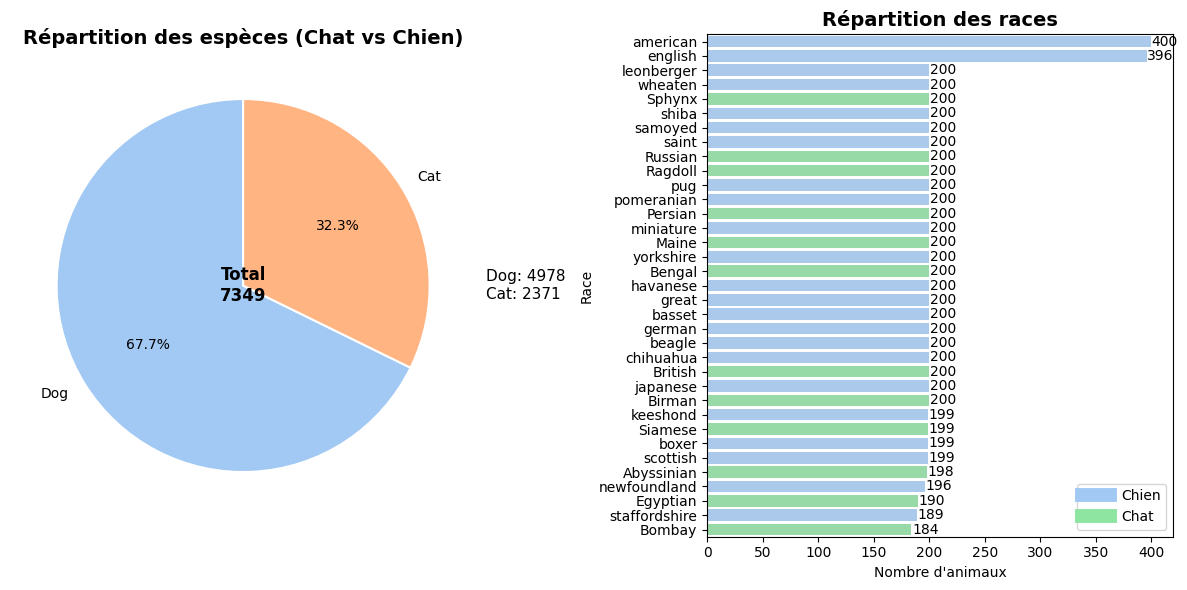

In [6]:
counts_species = df["SPECIES_NAME"].value_counts()
counts_breed = df["BREED_NAME"].value_counts()

species_per_breed = df.drop_duplicates("BREED_NAME").set_index("BREED_NAME")["SPECIES_NAME"] #j'ai voulu faire en sorte d'harmoniser les couleurs entre les deux graphiques mais je n'y arrive pas :'(
colors = {"Dog": sns.color_palette("pastel")[0],"Cat": sns.color_palette("pastel")[2]}
palette = [colors[species_per_breed[breed]] for breed in counts_breed.index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : espèces
colors_species = sns.color_palette("pastel", len(counts_species))
axes[0].pie(counts_species,labels=counts_species.index,autopct="%1.1f%%",startangle=90,colors=colors_species,wedgeprops={"edgecolor": "white", "linewidth": 1.5}) 
axes[0].set_title("Répartition des espèces (Chat vs Chien)", fontsize=14, fontweight="bold")
total = counts_species.sum()
axes[0].text(0, 0, f"Total\n{total}", ha='center', va='center', fontsize=12, fontweight='bold')
species_counts_text = "\n".join([f"{k}: {v}" for k, v in counts_species.items()]) # Ajouter le nombre exact de chaque espèce en légende
axes[0].text(1.3, 0, species_counts_text, fontsize=11, va='center')

# Deuxième graphique : races
sns.barplot(y=counts_breed.index,x=counts_breed.values,hue=counts_breed.index,palette=palette,legend=False,ax=axes[1])
axes[1].set_title("Répartition des races", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Nombre d'animaux")
axes[1].set_ylabel("Race")
for i, v in enumerate(counts_breed.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=10)

axes[1].legend(handles=[plt.Line2D([0], [0], color=colors["Dog"], lw=10, label="Chien"),plt.Line2D([0], [0], color=colors["Cat"], lw=10, label="Chat")],loc="lower right") #légendes chien chat en bas à droite 
plt.tight_layout()
plt.show()

on voit clairement que les deux tiers des données sont des chiens, et le tier restant est composé de chats.  
Il y a environ 200 individus de chacune des races, sauf pour les american et english où il y en a environ 400.

### B- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

nom de l'image : beagle_7


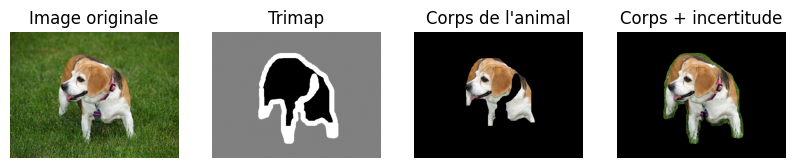

nom de l'image : Birman_105


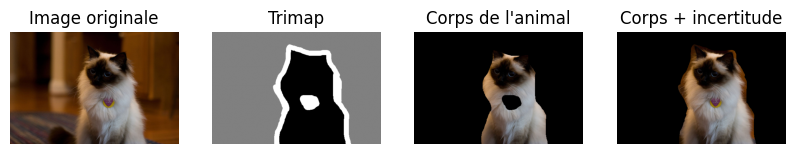

nom de l'image : japanese_chin_128


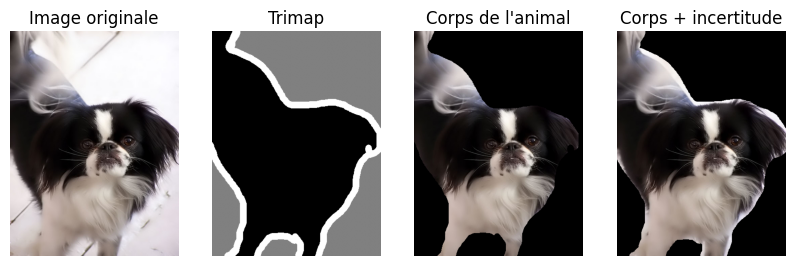

nom de l'image : Abyssinian_116


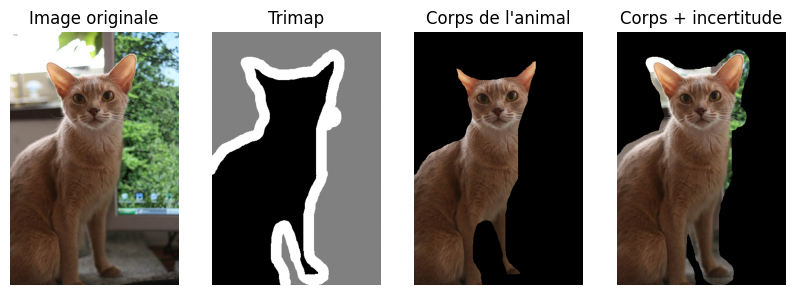

nom de l'image : shiba_inu_143


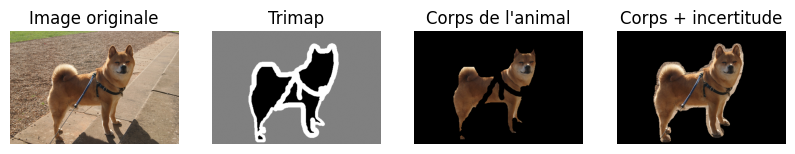

In [7]:
indices = np.random.choice(df.index, size=5, replace=False) # on choisit les indices des images que l'on va visualiser au hasard
 
img_dir = "oxford-iiit-pet/images/"                 # Chemin du répertoire qui contient les images
mask_dir = "oxford-iiit-pet/annotations/trimaps/"   # Chemin du répertoire qui contient les masques
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")] # On ignore les fichiers bizarres qui commencent par "._" qui sont dans le repertoire 

for indice in indices:
    image = masks[indice]
    name = os.path.splitext(image)[0]
    print("nom de l'image :",name)

    img_path = os.path.join(img_dir, name + ".jpg") # On récupère le path de l'image
    mask_path = os.path.join(mask_dir, image)       # On récupère le path du masque

    img = np.array(Image.open(img_path))            # On récupère les valeurs des pixels dans des np.array 
    mask = np.array(Image.open(mask_path))          # (on utilise la librairie PIL pour faire cela)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    plt.figure(figsize=(10,5))
    #On affiche nos 4 images
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### C- Identifier d’éventuels déséquilibres ou biais visuels

Je ne sais pas quoi dire ici

## 2- Classification Binaire

Nous cherchons à distinguer les chats des chiens à partir de leurs photos uniquement.
Pour cela, nous allons mettre en place plusieurs approches, en suivant la méthodologie vue en TP.

Un réseau de neurones convolutionnel (CNN) est particulièrement adapté pour la classification d’images, car il est capable d’apprendre automatiquement des caractéristiques visuelles comme les contours, textures ou motifs propres à chaque classe (ici chats et chiens).
Concrètement, dans ce notebook, nous proposerons trois réseaux de neurones pour réaliser cette tâche de classification :

- un CNN "naïf",
- un CNN entraîné sur un jeu de données augmenté,
- et un réseau utilisant le concept de “Transfer Learning”.

Pour ce dernier, nous utiliserons directement le jeu de données augmenté, puis nous effectuerons une phase de “Fine Tuning” afin d’en améliorer encore les performances.

Nous utiliserons TensorFlow par la suite.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Gestion des données d'entrée
Les réseaux de neurones que nous allons mettre en place nécessitent des données d’entrée de taille fixe. Nous commencerons donc par vérifier et contrôler la taille de nos images.

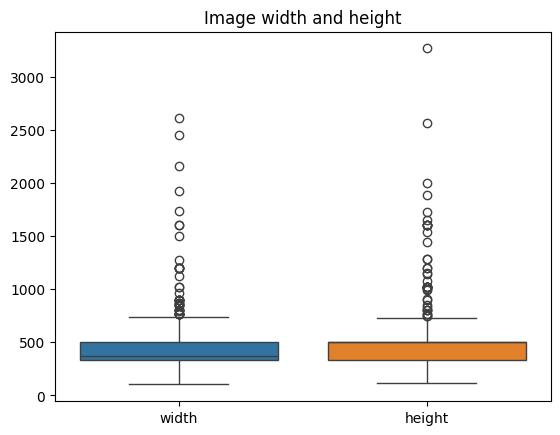

In [9]:
img_size = np.zeros((df.shape[0],2))
for i, image in enumerate(df['Image']) :
    img = img_to_array( load_img(img_dir + image) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

On constate que toutes les images n’ont pas les mêmes dimensions.
Nous allons donc devoir les redimensionner, en imposant une taille uniforme de 150 × 150 pixels.
(Il est possible de choisir une taille plus grande, 400 ou 500 par exemple, mais cela entraînerait des coûts de calcul plus élevés.)

Nous avons maintenant un choix à faire : soit redimensionner toutes les images avant de les séparer en ensembles d’entraînement, de validation et de test, soit séparer d’abord les ensembles puis redimensionner les images.
Pour rester cohérents avec la méthodologie vue en TP, nous choisissons la deuxième approche.

- On sépare en données d'entrainement, de validation et de test :

In [10]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data = df[["Image", "SPECIES_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df = train_test_split(data, test_size=N_train, stratify=data["SPECIES_NAME"])                    # On prend 5000
test_df, validation_df = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["SPECIES_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df.shape)
print("Validation set :", validation_df.shape)
print("Test set :", test_df.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df["SPECIES_NAME"].value_counts())
print("\nValidation :", validation_df["SPECIES_NAME"].value_counts())
print("\nTest :", test_df["SPECIES_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : SPECIES_NAME
Dog    3522
Cat    1678
Name: count, dtype: int64

Validation : SPECIES_NAME
Dog    678
Cat    322
Name: count, dtype: int64

Test : SPECIES_NAME
Dog    778
Cat    371
Name: count, dtype: int64


- On redimensionne nos images :

In [11]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1149 validated image filenames belonging to 2 classes.


Le réseau que nous allons définir est un CNN “naïf”, simple, constitué de plusieurs couches convolutionnelles et de pooling, suivi de couches entièrement connectées. Voici la logique derrière sa construction :
- Couche d’entrée (Input) : elle prend des images de taille (img_width, img_height, 3) — 3 canaux pour les couleurs RGB.
- Couches convolutionnelles (Conv2D) : elles détectent progressivement des motifs de plus en plus complexes dans les images.
- Couches de pooling (MaxPooling2D) : elles réduisent la taille des cartes de caractéristiques tout en conservant les informations importantes, ce qui diminue le coût de calcul et évite le surapprentissage.
- Couches denses (Dense) : après avoir aplati les cartes de caractéristiques avec Flatten(), ces couches permettent au réseau d’apprendre des combinaisons non linéaires pour la classification finale.
- Dropout : cette couche de régularisation permet de réduire le risque de surapprentissage en désactivant aléatoirement certaines neurones pendant l’entraînement.
- Couche de sortie : une seule unité avec une activation sigmoid, adaptée à la classification binaire (chat ou chien).

On fait une fonction car on aura besoin d'initialiser un réseau à nouveau, ça économise des lignes :)

The model we define is composed of 3 convolution blocks with the following form:  
* A $\texttt{Conv2D}$ layer with $3\times3$ filters and a $\texttt{Relu}$ activation function.<br>
  The first layer has 32 convolution filters, the second 64, and the third 96.  
* A $\texttt{MaxPooling}$ layer with a $2\times2$ window.

Followed by:  
* A $\texttt{Flatten}$ layer.  
* A $\texttt{Dense}$ layer with 64 neurons and a $\texttt{Relu}$ activation function.  
* A $\texttt{Dropout}$ layer with a 50% drop rate.  
* A $\texttt{Dense}$ layer with 1 neuron and a $\texttt{sigmoid}$ activation function.


In [12]:
def cnn_simple(nom):
    cnn = Sequential(name=nom)
    cnn.add(Input(shape=(img_width,img_height,3)))
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    return cnn

In [13]:
cnn_naif=cnn_simple("cnn_naif")
cnn_naif.summary()                  # Affichage de nos couches et du nombre de paramètres

Model: "cnn_naif"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle
Nous faisons face à un problème de classification binaire (chat vs chien).
Pour ce type de tâche, il est naturel de choisir comme fonction de perte (loss) la binary_crossentropy, qui mesure la distance entre les probabilités prédites par le réseau et les labels réels.

L’entraînement d’un réseau de neurones implique également le choix d’un optimiseur, ici on choisit Adam, avec un taux d’apprentissage (learning_rate) adapté. Nous allons entraîner notre modèle pendant un nombre d’époques défini (ici on prend epochs = 10).

La fonction suivante permet d’entraîner un CNN donné et de mesurer le temps d’apprentissage :

In [14]:
import time
epochs = 10

def Entrainement(cnn,epochs,train_generator):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history, t_learning_cnn

In [15]:
t_learning_cnn_naif, cnn_naif_history, t_learning_cnn_naif = Entrainement(cnn_naif,epochs,train_generator)

Entrainement de  cnn_naif
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - accuracy: 0.6781 - loss: 0.5981 - val_accuracy: 0.6780 - val_loss: 0.5692
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.7173 - loss: 0.5320 - val_accuracy: 0.7320 - val_loss: 0.5335
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.7563 - loss: 0.4873 - val_accuracy: 0.7660 - val_loss: 0.5120
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 279ms/step - accuracy: 0.7812 - loss: 0.4539 - val_accuracy: 0.7720 - val_loss: 0.4837
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8152 - loss: 0.4026 - val_accuracy: 0.7730 - val_loss: 0.5051
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.8294 - loss: 0.3712 - val_accuracy: 0.7810 - val_loss: 0.4775
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.8458 - loss: 0.3408 - val_accuracy: 0.7900 - val_loss: 0.5160
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 205s 782ms/step - accur

On crée les fonctions suivantes pour analyser les performances de notre réseau

In [16]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.9465 - loss: 0.1546
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7790 - loss: 0.5589
Train accuracy: 0.9465384483337402
Validation accuracy: 0.7789999842643738
Time Prediction: 29.59 seconds


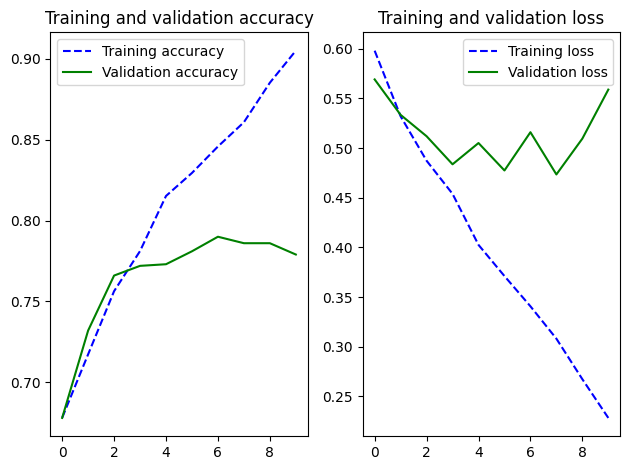

In [17]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

Nous obtenons des résultats corrects, mais nous observons un cas clair de sur-apprentissage (overfitting) : le modèle est très performant sur les données d’entraînement, mais il a du mal à généraliser sur de nouvelles images.

Pour y remédier, nous allons mettre en place une nouvelle approche.

Une solution efficace pour contrer le sur-apprentissage est l’augmentation de données (data augmentation).
Cette technique consiste à transformer les images existantes pour générer de nouvelles images artificiellement : par exemple en appliquant des rotations, décalages, zooms, retournements, etc.
L’idée est d’augmenter la diversité du jeu de données, ce qui aide le réseau à apprendre des caractéristiques plus robustes et à mieux généraliser.

Nous entraînerons ensuite notre deuxième CNN sur ce jeu de données augmenté.

- On commence par générer le nouveau jeu de données :

In [18]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    img_dir,
    x_col ='Image',
    y_col ='SPECIES_NAME',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


- Puis on initialise le nouveau CNN qu'on vient entrainer sur le nouveau jeu de données :

In [19]:
cnn_data_augmented = cnn_simple("cnn_data_augmented") # On initialise un nouveau réseau (identique au dernier)

cnn_data_augmented.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

t_learning_cnn_data_augmented, cnn_data_augmented_history, t_learning_cnn_data_augmented = Entrainement(cnn_data_augmented,epochs,train_generator_augmented) # on va l'entrainer avec les données augmentées cette fois

Entrainement de  cnn_data_augmented
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 439ms/step - accuracy: 0.6760 - loss: 0.6146 - val_accuracy: 0.6780 - val_loss: 0.6177
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 132s 507ms/step - accuracy: 0.6794 - loss: 0.5951 - val_accuracy: 0.6800 - val_loss: 0.6307
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.6854 - loss: 0.5730 - val_accuracy: 0.7200 - val_loss: 0.5725
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 139s 535ms/step - accuracy: 0.6923 - loss: 0.5718 - val_accuracy: 0.7210 - val_loss: 0.5410
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 68s 262ms/step - accuracy: 0.7133 - loss: 0.5552 - val_accuracy: 0.7170 - val_loss: 0.5572
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 250ms/step - accuracy: 0.7096 - loss: 0.5532 - val_accuracy: 0.7380 - val_loss: 0.5408
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 7523s 29s/step - accuracy: 0.7238 - loss: 0.5440 - val_accuracy: 0.7470 - val_loss: 0.5200
Epoch 8/10
 59/260 ━━━━━━━━━━━━━━━━━━━━ 4:48 1

KeyboardInterrupt: 

- On observe que les performances sont meilleures :

In [ ]:
t_prediction_cnn_data_augmented = Analyse_resultats(cnn_data_augmented,cnn_data_augmented_history)

Cependant le modèle met beaucoup plus de temps à s'entrainer. On obtient des résultats corrects, mais si on veut faire mieux, il faudrait beaucoup plus de données à notre disposition, ainsi que beaucoup plus de temps.  

La dernière solution pour avoir une meilleure précision est d'utiliser le **Transfer Learning**. On va s'aider d'un réseau pré-entrainé (ici VGG16) et on va y accroché notre propre *MLP classifier*.
On peut aussi combiner cette approche avec l'augmentation de données. Nous avons vu dans le TP que c'est ce qui donne les meilleurs résultats, nous allons donc directement mettre en place cela. 

In [ ]:
from tensorflow.keras.applications import VGG16 #on importe VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

In [ ]:
vgg_combined = Sequential(name="VGG16_data_augmented")
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG (on changera cela quand on fera le fine-tuning)
vgg_combined.summary()

- On entraine notre réseau sur le jeu de données augmenté :

In [ ]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement(vgg_combined,epochs,train_generator_augmented)

In [ ]:
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined,vgg_combined_history)

Les résultats qu'on obtient avec le Transfer Learning sont bons.

### Fine Tuning
Pour améliorer encore davantage la précision, nous allons maintenant effectuer une étape de Fine Tuning.

Le Fine Tuning consiste à défiger certaines couches du modèle pré-entraîné afin de réentraîner partiellement le réseau sur notre propre jeu de données.
L’idée est de permettre au modèle d’adapter ses représentations internes (les filtres appris dans les couches profondes) à notre problème spécifique, tout en conservant les connaissances générales issues de l’entraînement initial.

In [ ]:
# On recrée la même architecture que vgg_combined mais on rename
vgg_finetuned = tf.keras.Sequential(name="VGG16_data_augmented_finetuned")
vgg_finetuned.add(Input(shape=(img_width, img_height, 3)))
vgg_finetuned.add(conv_base)
vgg_finetuned.add(Flatten())
vgg_finetuned.add(Dense(256, activation='relu'))
vgg_finetuned.add(Dense(1, activation='sigmoid'))

conv_base.trainable = True # On rend la base convolutive entraînable
for layer in conv_base.layers[:15]: # On bloque les 15 premières couches (celles qui apprennent des caractéristiques générales)
    layer.trainable = False

vgg_finetuned.set_weights(vgg_combined.get_weights()) # On copie les poids du modèle précédent

vgg_finetuned.summary()


In [ ]:
epochs = 5

vgg_finetuned.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_finetuned = time.time()
vgg_finetuned_history = vgg_finetuned.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_finetuned = time.time() - t_learning_vgg_finetuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_finetuned))

In [ ]:
Analyse_resultats(vgg_finetuned,vgg_finetuned_history)

On obtient maintenant de très bon résultats. Si on le souhaite, on pourrait continuer le fine-tuning mais ce n'est pas necessaire. 

### Comparaison des modèles

In [ ]:
def Eval_Test(cnn):
    print("-------------",cnn.name,"-------------")
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = cnn.evaluate(test_generator)
    print(f"loss = {loss}")
    print(f"accuracy = {acc}\n")

In [ ]:
Eval_Test(cnn_naif)
Eval_Test(cnn_data_augmented)
Eval_Test(vgg_combined)
Eval_Test(vgg_finetuned)

Faire un petit texte qui parle des résultats

## 3- Classification Fine

On a très peu d'images par rapport au nombre de classes à apprendre. Le mlp va être très mauvais. On voit qu'il prédit la classe majoritaire parce qu'il est sous appris.

Il y a beaucoup trop de paramètres à apprendre par rapport à la quantité de données, de plus on perds touote l'information spatiale en faisant le flatten

On va réduire MASSIVEMENT la taille des images pour faciliter le travail du réseau (taille)

In [41]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data_breed = df[["Image", "BREED_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df_cf = train_test_split(data_breed, test_size=N_train, stratify=data_breed["BREED_NAME"])                    # On prend 5000
test_df_cf, validation_df_cf = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["BREED_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df_cf.shape)
print("Validation set :", validation_df_cf.shape)
print("Test set :", test_df_cf.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df_cf["BREED_NAME"].value_counts())
print("\nValidation :", validation_df_cf["BREED_NAME"].value_counts())
print("\nTest :", test_df_cf["BREED_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : BREED_NAME
american         283
english          280
miniature        142
saint            142
British          142
japanese         142
basset           142
wheaten          142
pug              142
Bengal           142
havanese         142
great            142
shiba            142
chihuahua        142
Sphynx           141
scottish         141
Birman           141
samoyed          141
yorkshire        141
Ragdoll          141
german           141
pomeranian       141
Russian          141
beagle           141
Siamese          141
Persian          141
keeshond         141
Maine            141
leonberger       141
boxer            141
Abyssinian       140
newfoundland     139
Egyptian         134
staffordshire    134
Bombay           130
Name: count, dtype: int64

Validation : BREED_NAME
american         54
english          54
beagle           28
Sphynx           28
Russian 

In [ ]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    target_size = (img_width, img_height),
    class_mode = 'sparse',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 35 classes.
Found 1000 validated image filenames belonging to 35 classes.
Found 1149 validated image filenames belonging to 35 classes.


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

### 1) A multilayer simple perceptron

We need to flatten the images (size 150*150) to a vector shape

In [ ]:
# Network definition

def mlp(nom, N_classes=35):
    mlp = Sequential(name=nom)
    mlp.add(Input(shape=(32, 32, 3)))
    mlp.add(Flatten())
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(N_classes, activation='softmax'))
    return mlp

In [49]:
mlp_simple=mlp("mlp_simple")
mlp_simple.summary()  

Model: "mlp_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,371 (1.58 MB)

 Trainable params: 414,371 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
import time
epochs = 10

def Entrainement_mlp(mlp,epochs,train_generator):
    print("Entrainement de ",mlp.name)
    mlp.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = Adam(),
        metrics = ['accuracy'])

    t_learning_mlp = time.time()
    
    mlp_history = mlp.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_mlp = time.time() - t_learning_mlp
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_mlp))
    
    return t_learning_mlp, mlp_history, t_learning_mlp

In [51]:
t_learning_mlp_naif, mlp_naif_history, t_learning_mlp_naif = Entrainement_mlp(mlp_simple,epochs,train_generator)

Entrainement de  mlp_simple
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.0462 - loss: 3.5953 - val_accuracy: 0.0670 - val_loss: 3.5200
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.0552 - loss: 3.5235 - val_accuracy: 0.0530 - val_loss: 3.5557
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.0617 - loss: 3.5054 - val_accuracy: 0.0710 - val_loss: 3.4889
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.0608 - loss: 3.5033 - val_accuracy: 0.0720 - val_loss: 3.4630
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.0583 - loss: 3.4927 - val_accuracy: 0.0680 - val_loss: 3.4527
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.0569 - loss: 3.4846 - val_accuracy: 0.0720 - val_loss: 3.4678
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.0600 - loss: 3.4735 - val_accuracy: 0.0720 - val_loss: 3.4576
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accura

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)
    predict_cnn = cnn.predict(validation_generator)

    y_true = validation_generator.classes
    y_pred = np.argmax(predict_cnn, axis=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    plot_training_analysis(cnn_history)
    return t_prediction_cnn


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.0612 - loss: 3.4462
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0660 - loss: 3.4552
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Train accuracy: 0.061153847724199295
Validation accuracy: 0.06599999964237213
Time Prediction: 16.27 seconds


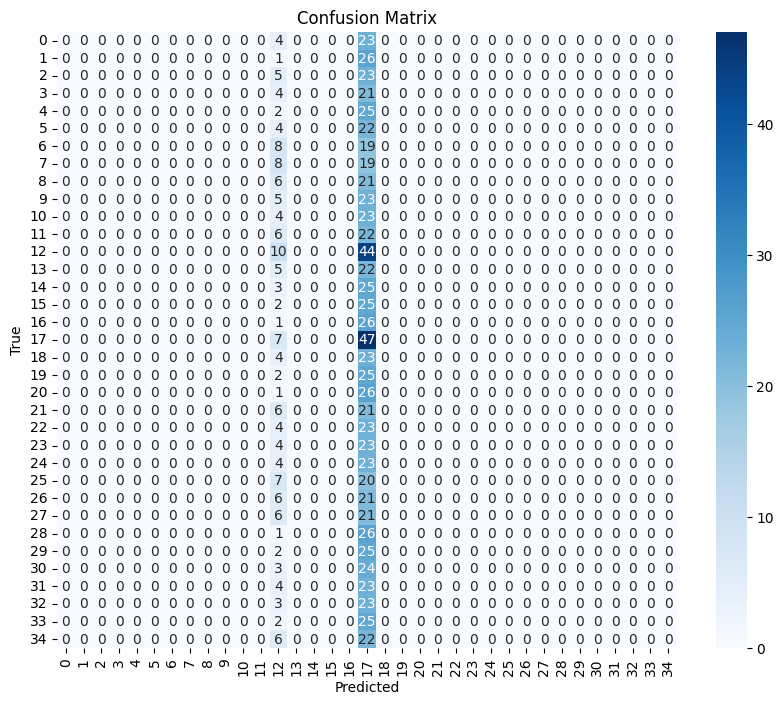

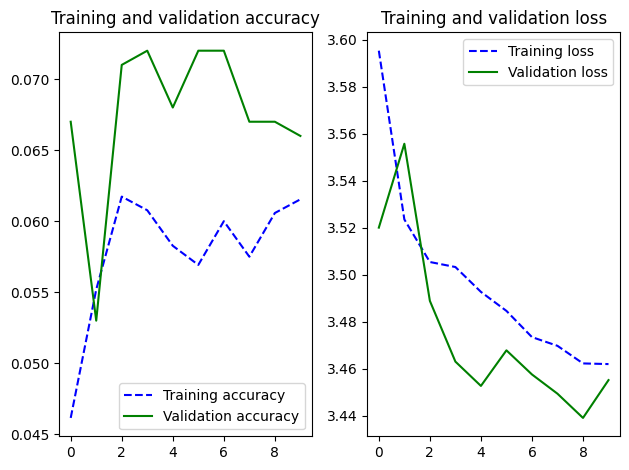

In [54]:
t_prediction_cnn_naif = Analyse_resultats(mlp_simple,mlp_naif_history)

### 2) CNN

In [56]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import MaxPool2D, MaxPooling2D

In [69]:
def CNN(nom,img_width,img_height, N_classes=35):
    model = Sequential(name=nom)
    model.add(Input(shape=(img_width, img_height, 3)))
    model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu'))
    model.add(MaxPool2D(pool_size = 2, strides = 2))
    model.add(Conv2D(filters = 64, kernel_size = 3,strides = 1, activation = 'relu'))
    model.add(MaxPool2D(pool_size = 2, strides = 2))
    model.add(Flatten())
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = N_classes, activation = 'softmax'))
    return model

In [70]:
cnn=CNN("CNN",img_width,img_height)
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,290,723 (81.22 MB)

 Trainable params: 21,290,723 (81.22 MB)

 Non-trainable params: 0 (0.00 B)

Entrainement de  CNN
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.0471 - loss: 3.5632 - val_accuracy: 0.0590 - val_loss: 3.4213
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 184ms/step - accuracy: 0.0887 - loss: 3.3226 - val_accuracy: 0.1020 - val_loss: 3.2053
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.1454 - loss: 3.0383 - val_accuracy: 0.1670 - val_loss: 2.9506
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.2519 - loss: 2.6253 - val_accuracy: 0.2000 - val_loss: 2.8401
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 194ms/step - accuracy: 0.4263 - loss: 1.9593 - val_accuracy: 0.1820 - val_loss: 3.0106
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 52s 198ms/step - accuracy: 0.6406 - loss: 1.1935 - val_accuracy: 0.1910 - val_loss: 3.4010
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 78s 299ms/step - accuracy: 0.8031 - loss: 0.6509 - val_accuracy: 0.1660 - val_loss: 4.0330
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accur

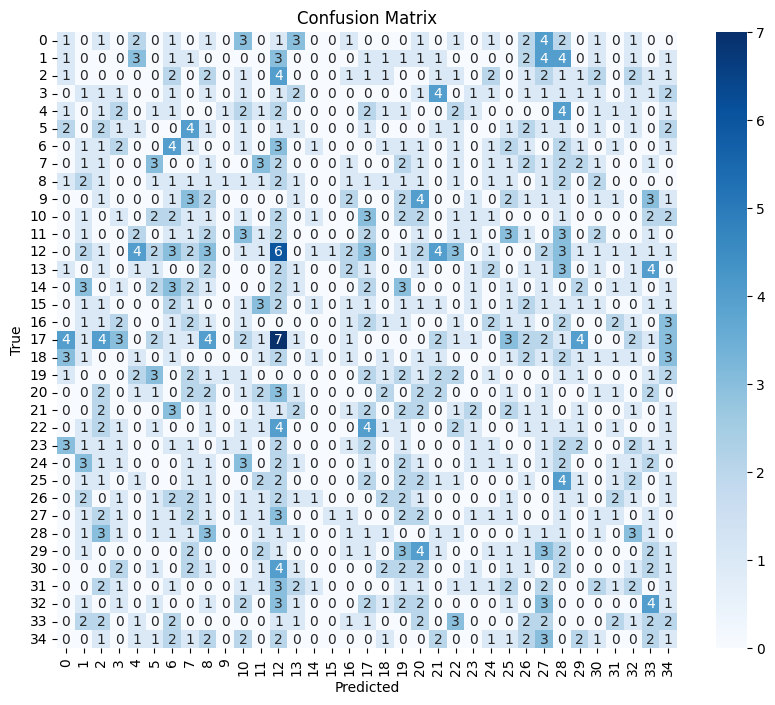

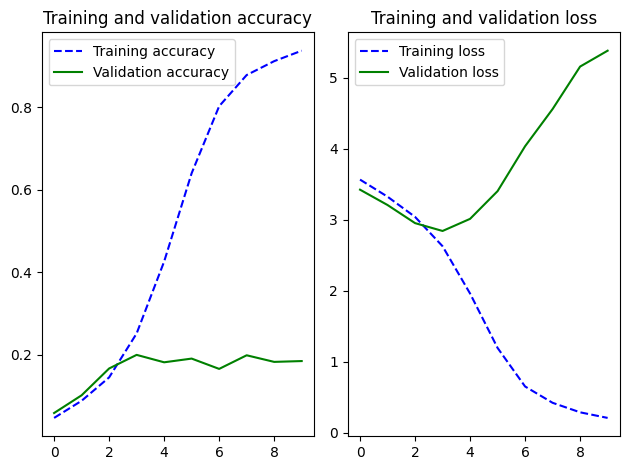

In [ ]:
t_learning_cnn, cnn_history, _ = Entrainement_mlp(cnn, epochs, train_generator)
t_prediction_cnn_naif = Analyse_resultats(cnn, cnn_history)

### 3) Data augmentation

In [71]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col ='Image',
    y_col ='BREED_NAME',
    target_size=(img_width,img_height),
    class_mode = 'sparse',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 35 classes.


In [72]:
CNN_data_augmented = CNN("CNN_data_augmented",img_width,img_height) # On initialise un nouveau réseau (identique au dernier)

# on va l'entrainer avec les données augmentées cette fois
t_learning_cnn_data_augmented, cnn_data_augmented_history, _ = Entrainement_mlp(CNN_data_augmented, epochs, train_generator_augmented)

Entrainement de  CNN_data_augmented
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 242ms/step - accuracy: 0.0492 - loss: 3.6165 - val_accuracy: 0.0540 - val_loss: 3.5292
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 257ms/step - accuracy: 0.0604 - loss: 3.5050 - val_accuracy: 0.0690 - val_loss: 3.4275
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - accuracy: 0.0750 - loss: 3.4020 - val_accuracy: 0.0880 - val_loss: 3.2633
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - accuracy: 0.0792 - loss: 3.3146 - val_accuracy: 0.0910 - val_loss: 3.2495
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.0915 - loss: 3.2790 - val_accuracy: 0.0940 - val_loss: 3.2311
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 81s 312ms/step - accuracy: 0.0965 - loss: 3.2284 - val_accuracy: 0.1180 - val_loss: 3.0222
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 78s 297ms/step - accuracy: 0.1162 - loss: 3.1907 - val_accuracy: 0.1480 - val_loss: 3.0023
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms

260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.1875 - loss: 2.8417
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.1640 - loss: 2.9267
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
Train accuracy: 0.1875
Validation accuracy: 0.164000004529953
Time Prediction: 22.34 seconds


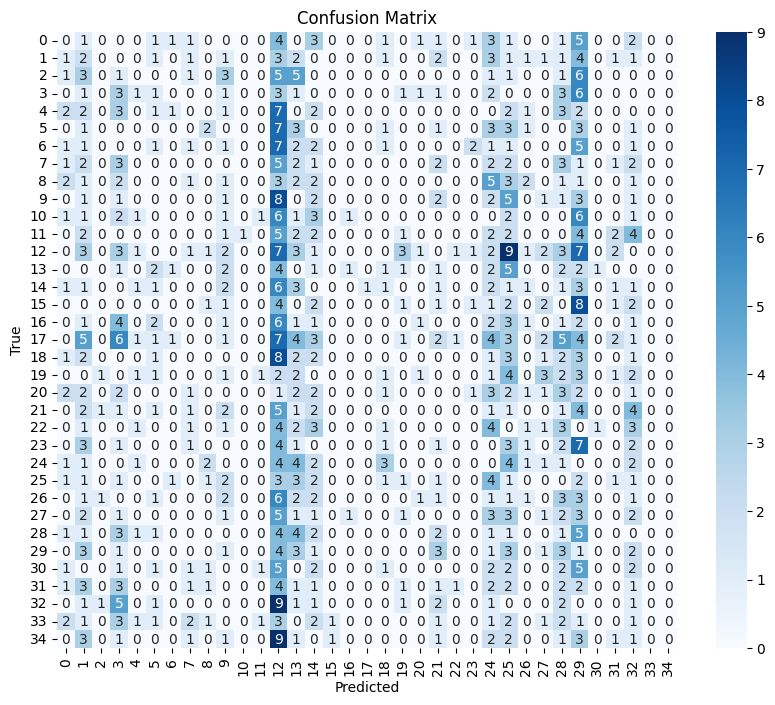

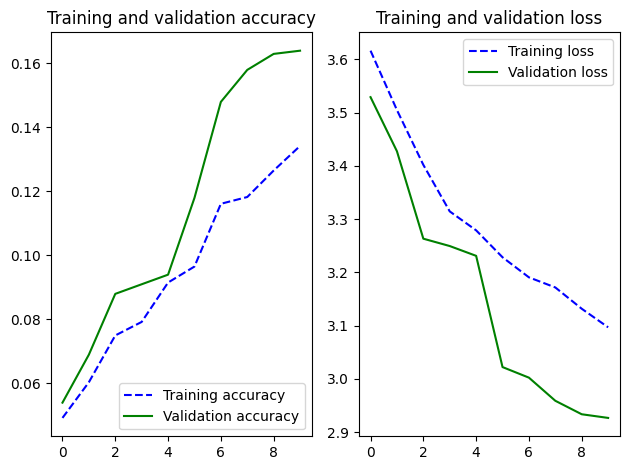

In [73]:
t_prediction_cnn_data_augmented = Analyse_resultats(CNN_data_augmented, cnn_data_augmented_history)

### 4) Transfer Learning : VGG16 + Data augmentation

In [74]:
from tensorflow.keras.applications import VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [75]:
vgg_combined = Sequential(name="VGG16_data_augmented")
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)

vgg_combined.add(Flatten())
vgg_combined.add(Dense(units = 256, activation = 'relu'))
vgg_combined.add(Dropout(0.5))
vgg_combined.add(Dense(units = 128, activation = 'relu'))
vgg_combined.add(Dense(units = 35, activation = 'softmax'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG (on changera cela quand on fera le fine-tuning)
vgg_combined.summary()

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,849,507 (64.28 MB)

 Trainable params: 2,134,819 (8.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement_mlp(vgg_combined,epochs,train_generator_augmented)
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined, vgg_combined_history)

### 5) Fine-tuning

In [ ]:
# On recrée la même architecture que vgg_combined mais on rename
vgg_finetuned = tf.keras.Sequential(name="VGG16_data_augmented_finetuned")
vgg_finetuned.add(Input(shape=(img_width, img_height, 3)))
vgg_finetuned.add(conv_base)
vgg_finetuned.add(Flatten())
vgg_finetuned.add(Dense(units = 256, activation = 'relu'))
vgg_finetuned.add(Dropout(0.5))
vgg_finetuned.add(Dense(units = 128, activation = 'relu'))
vgg_finetuned.add(Dense(units = 35, activation = 'softmax'))

conv_base.trainable = True # On rend la base convolutive entraînable
for layer in conv_base.layers[:15]: # On bloque les 15 premières couches (celles qui apprennent des caractéristiques générales)
    layer.trainable = False

vgg_finetuned.set_weights(vgg_combined.get_weights()) # On copie les poids du modèle précédent

vgg_finetuned.summary()

In [ ]:
epochs = 5

def Entrainement_mlp2(mlp,epochs,train_generator,lr=1e-4):
    print("Entrainement de ",mlp.name)
    mlp.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=lr),
        metrics = ['accuracy'])

    t_learning_mlp = time.time()
    
    mlp_history = mlp.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_mlp = time.time() - t_learning_mlp
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_mlp))
    
    return t_learning_mlp, mlp_history, t_learning_mlp

In [ ]:
t_learning_vgg_finetuned_augmented, vgg_finetuned_history, t_learning_vgg_finetuned = Entrainement_mlp2(vgg_finetuned,epochs,train_generator_augmented,lr=1e-4)
Analyse_resultats(vgg_finetuned,vgg_finetuned_history)

## 4- Segmentation des animaux

Using a U-net network

Data loader pour les images et masques

In [1]:
!pip install tensorflow.keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import random

class SegmentationDataLoader(Sequence):
    def __init__(self, df, img_dir, mask_dir,
                 img_size=(128,128), batch_size=20,
                 augment=False):

        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx*self.batch_size : (idx+1)*self.batch_size]

        X = []
        Y = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row["Image"])
            mask_path = os.path.join(self.mask_dir,
                                     row["Image"].replace(".jpg", ".png"))

            # Load image
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0

            # Load mask (trimap)
            mask = load_img(mask_path,
                            target_size=self.img_size,
                            color_mode="grayscale")
            mask = img_to_array(mask).astype(np.int32)

            # Convert 1,2,3 -> 0,1 (binarisation: animal vs fond)
            mask = np.where(mask == 1, 1, 0)

            # Data augmentation synchronisée
            if self.augment:
                if random.random() < 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

            X.append(img)
            Y.append(mask)

        return np.array(X), np.array(Y)


In [ ]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 128
img_height = 128

mask_dir = "./oxford-iiit-pet/annotations/trimaps"

train_loader = SegmentationDataLoader(
    train_df,
    img_dir,
    mask_dir,
    img_size=(img_width,img_height),
    batch_size=batch_size,
    augment=True
)

val_loader = SegmentationDataLoader(
    validation_df,
    img_dir,
    mask_dir,
    img_size=(img_width,img_height),
    batch_size=batch_size
)

test_loader = SegmentationDataLoader(
    test_df,
    img_dir,
    mask_dir,
    img_size=(img_width,img_height),
    batch_size=batch_size
)


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

### U-net model:

In [ ]:
import pix2pix
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# On extrait les couches de MobileNetV2 pour la partie encodeur du U-Net
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4 (Bottleneck)
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# L'encodeur est pré-entrainé sur ImageNet. Pourl'instant on fixe les poids
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

# Le décodeur contient des couches de upsampling
# les couches pix2pix upsample font des Conv2DTranspose + BatchNorm + ReLU
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # On garde trace des inputs quand on descend dans l'encodeur pour les skip-connections
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])  # on enlève le bottleneck

  # On remonte dans le décodeur en concatenant les skip-connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Dernière coucbe du modèle : on veut avoir une sortie de la taille de l'image d'entrée, on utilise une couche Conv2DTranspose
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
Unet = unet_model(output_channels=35)   # 35 classes pour la classification des races
Unet.summary()

t_learning_unet, unet_history, _ = Entrainement_mlp(Unet, epochs, train_generator)
t_prediction_unet_naif = Analyse_resultats(Unet, unet_history)

## 5- Analyse comparative